In [1]:
# Load and preview dataset
import datetime
import pandas as pd
import numpy as np

In [2]:
Synthetic = pd.read_csv('Synthetic_Data.csv', parse_dates=['date'])
Synthetic['ID'] = Synthetic.groupby(["country", "Series", 'S_type']).ngroup()
Synthetic.set_index('date', inplace =True)

Synthetic['ret'] = Synthetic.groupby('ID')['value'].pct_change()
Synthetic.dropna(inplace= True)

In [3]:
Synthetic_char = Synthetic[['country_gdp_factor', 'weekend_boost_factor','product_linear_trend','random_seris_type',
                            'white_noise', 'holiday_trend_factor', 'eu_industry_product_factor', 'product_seasonal_trend_factor',
                            'random_series_factor', 'wavelength', 'amplitude', 'phase', 'ID']]

Synthetic_char= Synthetic_char.reset_index().set_index(['date', 'ID'])

Synthetic_ret = Synthetic[['ID', 'ret']].pivot(columns='ID', values='ret')
Synthetic_val = Synthetic[['ID', 'value']].pivot(columns='ID', values='value')

In [4]:
Synthetic_ret.plot(figsize=(24,8))

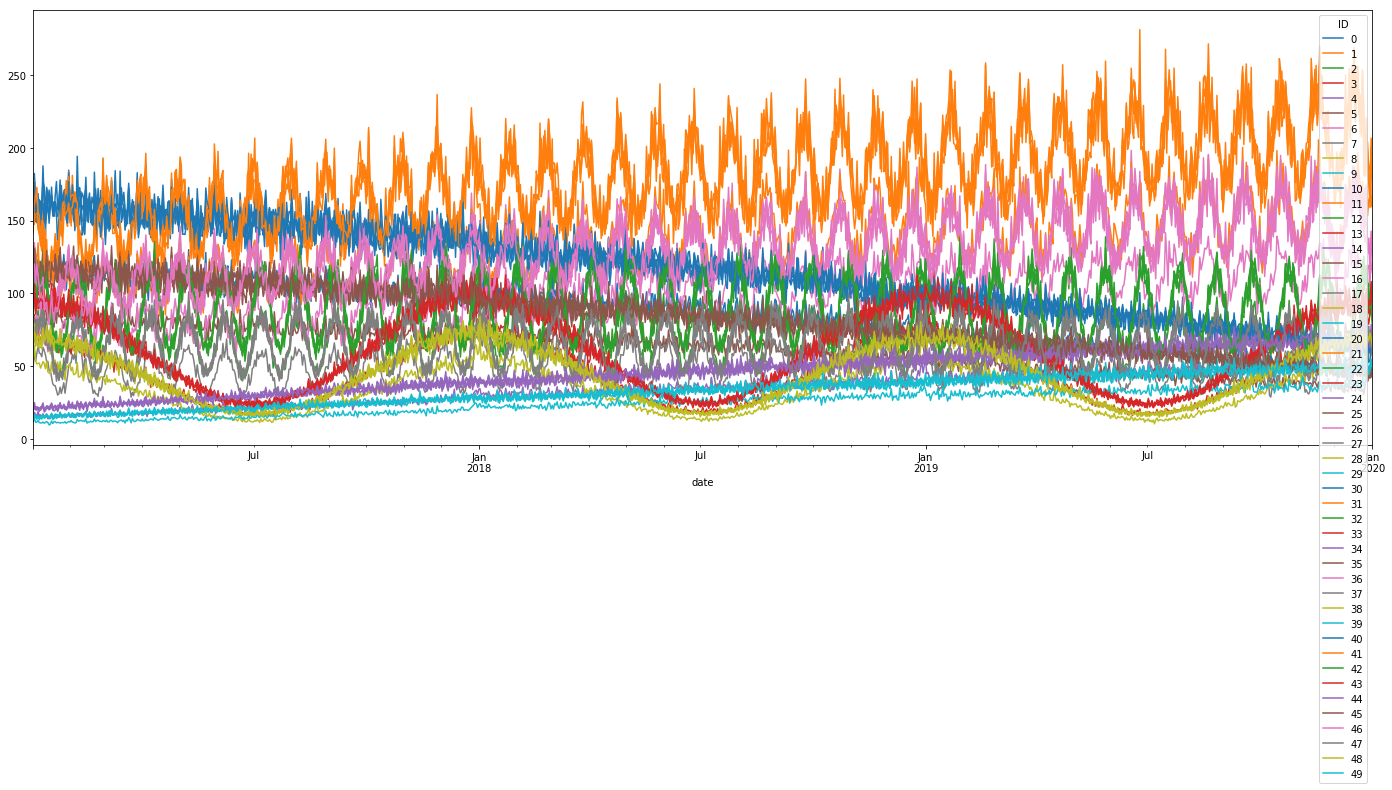

In [5]:
Synthetic_val.plot(figsize=(24,8))

In [6]:
Synthetic

,country,Series,S_type,base_amount,country_gdp_factor,weekend_boost_factor,product_linear_trend,random_seris_type,white_noise,holiday_trend_factor,eu_industry_product_factor,product_seasonal_trend_factor,random_series_factor,total_factor,value,wavelength,amplitude,phase,ID,ret
date,,,,,,,,,,,,,,,,,,,,
2017-01-02,USA,s1,up_trend,1,1.0,1.0,1.002099,2.110684,0.937645,1.0,1.022,1.000000,9.615306,19.488838,19.488838,0.0,0.00,0.00,44,-0.065255
2017-01-02,USA,s1,down_up_trend,1,1.0,1.0,2.000912,7.016039,0.992464,1.0,1.022,1.149178,9.615306,157.338933,157.338933,30.0,0.15,7.00,41,-0.018519
2017-01-02,USA,s1,down_trend,1,1.0,1.0,2.498631,6.450322,1.000955,1.0,1.022,1.000000,9.615306,158.530309,158.530309,0.0,0.00,0.00,40,0.001810
2017-01-02,USA,s1,seasonality,1,1.0,1.0,1.000000,5.965674,0.994257,1.0,1.022,1.599911,9.615306,93.254095,93.254095,365.0,0.60,91.25,43,-0.003407
2017-01-02,USA,s1,reversal,1,1.0,1.0,1.000000,8.732988,0.997521,1.0,1.022,1.062374,9.615306,90.944405,90.944405,30.0,0.30,0.00,42,0.015026
2017-01-02,USA,s2,up_trend,1,1.0,1.0,1.002099,2.110684,1.093810,1.0,1.022,1.000000,6.944850,16.420607,16.420607,0.0,0.00,0.00,49,0.062499
2017-01-02,USA,s2,down_up_trend,1,1.0,1.0,2.000912,7.016039,1.029059,1.0,1.022,1.149178,6.944850,117.831564,117.831564,30.0,0.15,7.00,46,0.080467
2017-01-02,USA,s2,down_trend,1,1.0,1.0,2.498631,6.450322,1.048857,1.0,1.022,1.000000,6.944850,119.981260,119.981260,0.0,0.00,0.00,45,0.130371
2017-01-02,USA,s2,seasonality,1,1.0,1.0,1.000000,5.965674,1.015181,1.0,1.022,1.599911,6.944850,68.772165,68.772165,365.0,0.60,91.25,48,-0.036668


In [7]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
import copy
from sklearn.preprocessing import StandardScaler
import scipy.special as special
import scipy.sparse as sp

import pickle
import os


import tensorflow as tf
#import tensorflow_addons as tfa
import keras

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, GRU, Input
from tensorflow.keras.optimizers import SGD, Adam


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dropout, Dense, LeakyReLU, GRU, Concatenate, Reshape, Softmax, Attention
from tensorflow.keras import activations
from tensorflow.keras.models import Model
#from keras.layers import LeakyReLU

from spektral.layers import  GCSConv, DiffusionConv, GATConv, ARMAConv, GCNConv

from tensorflow.keras.regularizers import l2

Using TensorFlow backend.


In [8]:
def generate_graph_seq2seq_io_data(
        df, x_offsets, y_offsets, add_time_in_day=True, add_day_in_week=False, scaler=None
):
    """
    Generate samples from
    :param df:
    :param x_offsets:
    :param y_offsets:
    :param add_time_in_day:
    :param add_day_in_week:
    :param scaler:
    :return:
    # x: (epoch_size, input_length, num_nodes, input_dim)
    # y: (epoch_size, output_length, num_nodes, output_dim)
    """

    num_samples, num_nodes = df.shape
    data = np.expand_dims(df.values, axis=-1)
    data_list = [data]
    if add_time_in_day:
        time_ind = (df.index.values - df.index.values.astype("datetime64[D]")) / np.timedelta64(1, "D")
        time_in_day = np.tile(time_ind, [1, num_nodes, 1]).transpose((2, 1, 0))
        data_list.append(time_in_day)
    if add_day_in_week:
        day_in_week = np.zeros(shape=(num_samples, num_nodes, 7))
        day_in_week[np.arange(num_samples), :, df.index.dayofweek] = 1
        data_list.append(day_in_week)

    data = np.concatenate(data_list, axis=-1)
    # epoch_len = num_samples + min(x_offsets) - max(y_offsets)
    x, y = [], []
    # t is the index of the last observation.
    min_t = abs(min(x_offsets))
    max_t = abs(num_samples - abs(max(y_offsets)))  # Exclusive
    for t in range(min_t, max_t):
        x_t = data[t + x_offsets, ...]
        y_t = data[t + y_offsets, ...]
        x.append(x_t)
        y.append(y_t)
    x = np.stack(x, axis=0)
    y = np.stack(y, axis=0)
    return x, y



def plot_loss(dic):
    plt.figure(figsize=(12,5))
    #plt.subplot(1, 2, 1)
    plt.plot(dic['loss'], label='Training loss ')
    plt.plot(dic['val_loss'], label='Validation loss ')
    plt.legend(frameon=False)
    plt.title('train and validation loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    #plt.savefig('daily_loss.png', dpi = 400)
    plt.show()


    
def MSE(original, imputed):
    # calculate Mean Squared Error
    return np.square(original-imputed).mean()

def MPE(y_true, y_pred, threshold=0.1):
    v = np.copy(y_true)
    np.place(v, v==0, threshold)
    #v = np.clip(np.abs(y_true), threshold, None)
    diff = np.abs((y_true - y_pred) / v)
    return np.mean(diff, axis=-1).mean()

"""
def R_squared(original, predicted):
    Differ = np.square(original-predicted)
    m = np.mean(original) 
    denom = np.square(original - m)
    R_sq = 1 - ((Differ.sum())/denom.sum())
    return R_sq
"""
def R_squared(original, predicted):
    Differ = np.square(original-predicted)
    #m = np.mean(original) 
    denom = np.square(original)
    R_sq = 1 - ((Differ.sum())/denom.sum())
    return R_sq

def Get_performance(Y_true, Y_pred): 
    print ("R2 : ", np.round(R_squared(Y_true, Y_pred), 4))
    print ("MSE",  np.round(MSE(Y_true, Y_pred), 4))
    print ("MPE", np.round(MPE(Y_true, Y_pred), 4))
    
    return (np.round(R_squared(Y_true, Y_pred), 4), np.round(MSE(Y_true, Y_pred), 4), np.round(MPE(Y_true, Y_pred), 4)) 
        

def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))

def mape(y_true, y_pred, threshold=0.1):
    v = np.clip(np.abs(y_true), threshold, None)
    diff = np.abs((y_true - y_pred) / v)
    return 100.0 * np.mean(diff, axis=-1).mean()

def get_metrics(y, yp):
    return {
        "rmse": np.round(rmse(y, yp), 4),
        "mae": np.round(mae(y, yp), 4),
        "mape": np.round(mape(y, yp),4),
        #"MPE": np.round(MPE(y, yp), 4),
        #"R2": np.round(R_squared(y, yp),4)
        
    }


#if necessary

def top_k_filtering(logits, top_k=10):
    "Set values less than the k'th largest to 0."
    kth_largest = tf.math.top_k(logits, top_k)[0][-1]
    return tf.where(logits < kth_largest, 0, logits)

In [9]:
n_day = len(Synthetic_char.groupby('date').size())
n_firms = len(Synthetic_char.groupby('ID').size())

In [14]:
n_day 

1095

In [15]:
#how many time lag I wanna use
n_lag = 36
#how many time period I wanna predict
n_forward = 1

x_offsets = np.sort(np.arange(-n_lag+1, 1, 1))
y_offsets = np.sort(np.arange(1, n_forward+1, 1))

In [16]:
x, y = generate_graph_seq2seq_io_data(
    Synthetic_ret,
    x_offsets=x_offsets,
    y_offsets=y_offsets,
    add_time_in_day=False,
    add_day_in_week=False,
    )

In [17]:
#Do Standardization
#standardization
scaler = StandardScaler()
#scaler.fit(data)
data_stand = scaler.fit_transform(Synthetic_char)
#data_stand = pd.DataFrame(data_stand, index=data.index,  columns=data.columns)  
features = data_stand.reshape(n_day, n_firms, Synthetic_char.shape[1])
features = features[n_lag-1:-n_forward,:,:]

In [18]:
x = np.transpose(x, (0, 2, 1, 3))
y = np.transpose(y, (0, 2, 1, 3))

#reshape to made three dimensional tensor
x = x.reshape(x.shape[0],x.shape[1],x.shape[2] )
y = y.reshape(y.shape[0],y.shape[1],y.shape[2] )

#x = np.transpose(x, (0, 2, 1))
#y = np.transpose(y, (0, 2, 1))



x = x.astype('float32')
y = y.astype('float32')

In [19]:
AdPos = np.empty([x.shape[0], x.shape[1], x.shape[1]])
AdNeg = np.empty([x.shape[0], x.shape[1], x.shape[1]])

for i in range(0, x.shape[0]):
    aa = np.corrcoef(x[i],rowvar=True)
    P_val =  np.abs((aa*np.sqrt(n_lag-2))/(np.sqrt(1-np.square(aa))))
    P_val  = np.nan_to_num(P_val, nan=0.0, posinf=0, neginf=0)
    ab = n_lag/2 - 1
    P_val = 2*special.btdtr(ab, ab, 0.5*(1 - abs(np.float64(aa))))
    P_val = np.nan_to_num(P_val, nan=0.0, posinf=0, neginf=0)
    P_val  = np.where(P_val>0.05, 0, 1)
    
    Adjac = aa*P_val
    #adj_matrix[i] = P_val 
    
    AdPos[i] =  np.where(Adjac > 0,1,0 )
    AdNeg[i] =  np.where(Adjac < 0,1,0 )

/home/ajim/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [39]:
np.nonzero(AdNeg)

(array([ 47,  47, 402, 402, 403, 403, 404, 404, 573, 573, 577, 577, 578,
        578, 579, 579]),
 array([ 5, 32, 15, 22, 15, 22, 15, 22,  5, 15,  5, 15,  5, 15,  5, 15]),
 array([32,  5, 22, 15, 22, 15, 22, 15, 15,  5, 15,  5, 15,  5, 15,  5]))

In [21]:
x_train = x[:600,:,:]
y_train = y[:600,:,:]



x_val = x[600:800,:,:]
y_val = y[600:800,:,:]


x_test = x[800:,:,:]
y_test = y[800:,:,:]


features_train  = features[:600,:,:]
features_val  =   features[600:800,:,:]
features_test  =  features[800:,:,:]




adj_pos_train = AdPos[:600,:,:]
adj_pos_val = AdPos[600:800,:,:]
adj_pos_test = AdPos[800:,:,:]

adj_neg_train = AdNeg[:600,:,:]
adj_neg_val = AdNeg[600:800,:,:]
adj_neg_test = AdNeg[800:,:,:]


In [22]:
adj_neg_test.shape

(259, 50, 50)

In [23]:
adj_pos_test.shape

(259, 50, 50)

In [24]:
features_test.shape

(259, 50, 12)

In [26]:
x_test.shape

(259, 50, 36)

In [27]:
learning_rate = 0.001
batch_size =24
epochs = 100
seed = 42
verbose = 1

In [28]:
tf.keras.backend.clear_session()

In [29]:
## Define Model

inputs_ret = Input(shape=(x.shape[1], x.shape[2], ))
inputs_feat = Input(shape=(features.shape[1], features.shape[2], ))
inputs_adj_pos = Input(shape=(features.shape[1],features.shape[1], ))
inputs_adj_neg = Input(shape=(features.shape[1],features.shape[1], ))
#inputs_3 = Input(shape=(data_shape[1],k, ))

GAT_output_P, Att_weights_P =  GATConv(16, attn_heads=4, concat_heads=True, dropout_rate=0.3, return_attn_coef=True, 
                                   activation='relu', use_bias=False)([inputs_ret, inputs_adj_pos])
Att_weights_P = tf.math.reduce_mean(Att_weights_P, axis=2)

GAT_output_P_2 =  GATConv(16, attn_heads=4, concat_heads=True, dropout_rate=0.3, return_attn_coef=False, 
                        activation='relu', use_bias=True)([inputs_feat, inputs_adj_pos])

diff_out = DiffusionConv(16, K=6, activation='tanh')([inputs_feat, Att_weights_P])
#diff_out = ARMAConv(16, order=2, iterations=1, share_weights=False, gcn_activation='relu', dropout_rate=0.0, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)


con_out_P_2 = Concatenate(axis=-1)([diff_out, GAT_output_P_2, GAT_output_P])
dense_P = Dense(8, activation='relu')(con_out_P_2)



GAT_output_N, Att_weights_N =  GATConv(16, attn_heads=4, concat_heads=True, dropout_rate=0.3, return_attn_coef=True, 
                                   activation='relu', use_bias=False)([inputs_ret, inputs_adj_neg])
Att_weights_N = tf.math.reduce_mean(Att_weights_N, axis=2)

#con_out_N = Concatenate(axis=-1)([GAT_output_N, GAT_output_NF])

GAT_output_N_2 =  GATConv(16, attn_heads=4, concat_heads=True, dropout_rate=0.3, return_attn_coef=False, 
                        activation='relu', use_bias=True)([inputs_feat, inputs_adj_neg])

diff_out_N = DiffusionConv(16, K=6, activation='tanh')([inputs_feat, Att_weights_N])
con_out_N_2 = Concatenate(axis=-1)([diff_out_N, GAT_output_N_2, GAT_output_N])
dense_N = Dense(8, activation='relu')(con_out_N_2)


con_out = Concatenate(axis=-1)([dense_P, dense_N])
dense_out = Dense(8, activation='linear')(con_out)
dense_out = Dropout(0.2)(dense_out)
outputs = Dense(1)(dense_out)




In [30]:
model = Model(inputs=[inputs_ret, inputs_feat, inputs_adj_pos, inputs_adj_neg], outputs=outputs)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=["mae", "mape"])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 36)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 50, 50)]     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 50, 50)]     0                                            
__________________________________________________________________________________________________
gat_conv (GATConv)              ((None, 50, 64), (No 2432        input_1[0][0]                    
                                                                 input_3[0][0]         

In [31]:
hists = model.fit(x= [x_train, features_train, adj_pos_train, adj_neg_train],
                  y= y_train, verbose=verbose, epochs=500,
                  batch_size=batch_size, #validation_split=0.1, 
                  validation_data=([x_val, features_val, adj_pos_val, adj_neg_val], y_val),
                  callbacks=[EarlyStopping(#monitor="val_mean_absolute_error", 
                      monitor="val_loss", patience=20, restore_best_weights=True)], )

Epoch 1/500
25/25 [==============================] - 1s 42ms/step - mape: 1460.2180 - loss: 0.0505 - mae: 0.1728 - val_loss: 0.0097 - val_mae: 0.0786 - val_mape: 545.9288
Epoch 2/500
25/25 [==============================] - 0s 16ms/step - mape: 878.7545 - loss: 0.0164 - mae: 0.1011 - val_loss: 0.0082 - val_mae: 0.0722 - val_mape: 467.8437
Epoch 3/500
25/25 [==============================] - 0s 16ms/step - mape: 817.9741 - loss: 0.0111 - mae: 0.0830 - val_loss: 0.0073 - val_mae: 0.0680 - val_mape: 424.1330
Epoch 4/500
25/25 [==============================] - 0s 16ms/step - mape: 442.1117 - loss: 0.0087 - mae: 0.0737 - val_loss: 0.0065 - val_mae: 0.0642 - val_mape: 416.0390
Epoch 5/500
25/25 [==============================] - 0s 16ms/step - mape: 374.8157 - loss: 0.0077 - mae: 0.0692 - val_loss: 0.0061 - val_mae: 0.0624 - val_mape: 402.1872
Epoch 6/500
25/25 [==============================] - 0s 16ms/step - mape: 432.7042 - loss: 0.0070 - mae: 0.0661 - val_loss: 0.0059 - val_mae: 0.0610 

Epoch 49/500
25/25 [==============================] - 0s 15ms/step - mape: 348.4361 - loss: 0.0038 - mae: 0.0489 - val_loss: 0.0036 - val_mae: 0.0475 - val_mape: 349.7799
Epoch 50/500
25/25 [==============================] - 0s 16ms/step - mape: 360.9795 - loss: 0.0038 - mae: 0.0486 - val_loss: 0.0036 - val_mae: 0.0474 - val_mape: 339.6980
Epoch 51/500
25/25 [==============================] - 0s 16ms/step - mape: 424.6178 - loss: 0.0038 - mae: 0.0486 - val_loss: 0.0036 - val_mae: 0.0473 - val_mape: 345.5463
Epoch 52/500
25/25 [==============================] - 0s 16ms/step - mape: 368.7897 - loss: 0.0037 - mae: 0.0485 - val_loss: 0.0036 - val_mae: 0.0474 - val_mape: 344.1244
Epoch 53/500
25/25 [==============================] - 0s 16ms/step - mape: 374.1207 - loss: 0.0038 - mae: 0.0485 - val_loss: 0.0036 - val_mae: 0.0472 - val_mape: 345.7965
Epoch 54/500
25/25 [==============================] - 0s 16ms/step - mape: 362.8974 - loss: 0.0037 - mae: 0.0484 - val_loss: 0.0036 - val_mae: 0.

Epoch 97/500
25/25 [==============================] - 0s 16ms/step - mape: 363.8747 - loss: 0.0035 - mae: 0.0468 - val_loss: 0.0035 - val_mae: 0.0465 - val_mape: 345.2571
Epoch 98/500
25/25 [==============================] - 0s 15ms/step - mape: 398.5623 - loss: 0.0035 - mae: 0.0468 - val_loss: 0.0035 - val_mae: 0.0464 - val_mape: 338.1475
Epoch 99/500
25/25 [==============================] - 0s 16ms/step - mape: 367.7437 - loss: 0.0035 - mae: 0.0467 - val_loss: 0.0035 - val_mae: 0.0465 - val_mape: 335.4102
Epoch 100/500
25/25 [==============================] - 0s 15ms/step - mape: 352.4677 - loss: 0.0035 - mae: 0.0466 - val_loss: 0.0035 - val_mae: 0.0466 - val_mape: 329.7584
Epoch 101/500
25/25 [==============================] - 0s 16ms/step - mape: 377.7340 - loss: 0.0035 - mae: 0.0466 - val_loss: 0.0035 - val_mae: 0.0464 - val_mape: 334.4161
Epoch 102/500
25/25 [==============================] - 0s 15ms/step - mape: 428.9876 - loss: 0.0034 - mae: 0.0465 - val_loss: 0.0035 - val_mae:

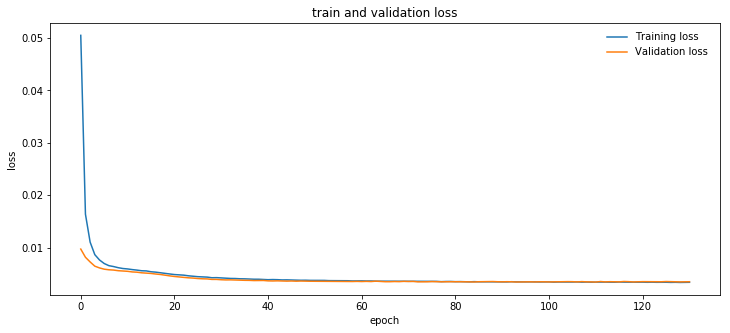

In [32]:
plot_loss(hists.history)

In [33]:
train_predicted = model.predict([x_train, features_train, adj_pos_train, adj_neg_train])
get_metrics(y_train.flatten(), train_predicted.flatten())

{'mae': 0.0437, 'mape': 38.2407, 'rmse': 0.0549}

In [34]:
val_predicted = model.predict([x_val, features_val, adj_pos_val, adj_neg_val])
get_metrics(y_val.flatten(), val_predicted.flatten())

{'mae': 0.0463, 'mape': 40.2388, 'rmse': 0.0586}

In [35]:
test_predicted = model.predict([x_test, features_test, adj_pos_test, adj_neg_test ])
get_metrics(y_test.flatten(), test_predicted.flatten())

{'mae': 0.0465, 'mape': 40.5913, 'rmse': 0.0585}

In [42]:
test_predicted.shape

(259, 50, 1)

In [43]:
pred_test_2  =  test_predicted.reshape(test_predicted.shape[0], test_predicted.shape[1])

In [45]:
DYGAP_test_result = pd.DataFrame(pred_test_2, index = Synthetic_ret.index[-pred_test_2.shape[0]:], columns = Synthetic_ret.columns)

In [50]:
DYGAP_test_result.to_csv("DYGAP_test_result.csv")

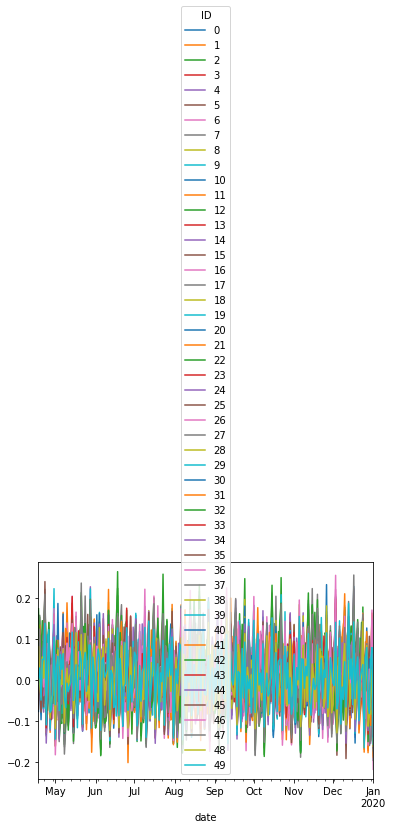

In [49]:
DYGAP_test_result.plot()

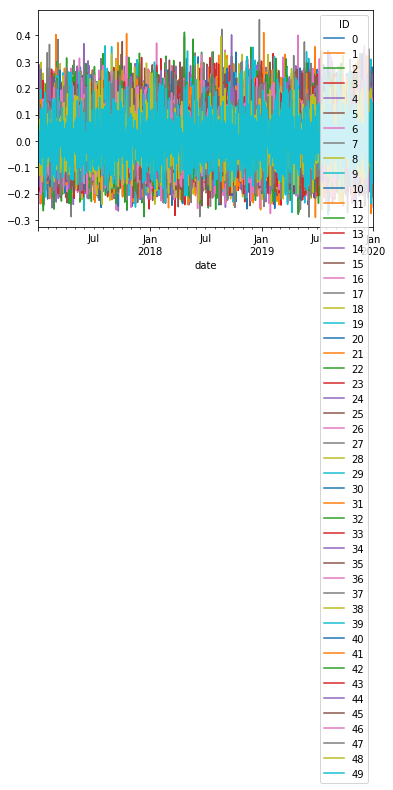

In [48]:
Synthetic_ret.plot()